# COSMOS2020 catalogue analysis 
Modified by Shirui Wei

source code: https://github.com/cosmic-dawn/cosmos2020-readcat

COSMOS2020 catalogue: https://cosmos2020.calet.org/


The Notebook is divided in the following sections:

* **Parameters specification**: COSMOS2020 with Farmer.
* **Data preparation**: select area, correct MW extinction, correct for photometric offset
* **Data output**: keep specific columns, add AB magnitude and change flux'unit from uJy to erg/cm2/s/Hz.
* **Data visualization**: sky map, redshift and color distributions

In [37]:
%matplotlib inline 
import numpy as np 
from matplotlib import pyplot as plt 
from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy import table

## COSMOS2020 catalogue Farmer Version

COSMOS2020_FARMER_R1_v2.2_p3.fits

In [2]:
# Specify the version of the catalog and the folder with the input/output files
catversion = 'Farmer'  # this string can be either 'Classic' or 'Farmer'
dir_in = '/data/home/wsr/WorkSpace/data/COSMOS2020/'  
dir_out = './'  # the directory where the output of this notebook will be stored

In [3]:
# Chose the SED fitting code: 
# set to 'lp' for LePhare results or
# set to 'ez' for EAZY
fitversion = 'ez'  

In [4]:
# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'cgs' # 'cgs' or 'uJy'

There are several pararemeters regarding the telescope filters used for observations. They are collectively stored in a dictionary. 

In [5]:
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4'] # micrometer  
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}

--------------------
## Data preparation

This section includes corrections due to Milky Way foreground extinction, photometric offsets, and flux loss in case of aperture photometry. Here, a subsample of the catalogue (either by rows or columns) can also be selected, and the table re-formatted to be saved as a different file.

In [6]:
# Upload the main catalogue
cat0 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.2_p3.fits'.format(catversion.upper()),format='fits',hdu=1)

In [7]:
# Create a mask to restrict the analysis to a subset of filters (optional)
ez_filt_not_use = ['GALEX_FUV', 'GALEX_NUV','SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp']
filt_use = list(set(filt_name) - set(ez_filt_not_use))
filt_mask = [i in filt_use for i in filt_name]

In [8]:
# Have a quick look inside the table
cat0[[0,-1]]

ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,FLAG_HSC,FLAG_SUPCAM,FLAG_UDEEP,FLAG_UVISTA,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,CFHT_ustar_CHISQ,CFHT_ustar_DRIFT,CFHT_ustar_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_y_MAGERR,HSC_y_CHISQ,HSC_y_DRIFT,HSC_y_VALID,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,UVISTA_Y_MAGERR,UVISTA_Y_CHISQ,UVISTA_Y_DRIFT,UVISTA_Y_VALID,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_J_MAGERR,UVISTA_J_CHISQ,UVISTA_J_DRIFT,UVISTA_J_VALID,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_H_MAGERR,UVISTA_H_CHISQ,UVISTA_H_DRIFT,UVISTA_H_VALID,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Ks_MAGERR,UVISTA_Ks_CHISQ,UVISTA_Ks_DRIFT,UVISTA_Ks_VALID,UVISTA_NB118_FLUX,UVISTA_NB118_FLUXERR,UVISTA_NB118_MAG,UVISTA_NB118_MAGERR,UVISTA_NB118_CHISQ,UVISTA_NB118_DRIFT,UVISTA_NB118_VALID,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB427_MAGERR,SC_IB427_CHISQ,SC_IB427_DRIFT,SC_IB427_VALID,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB464_MAGERR,SC_IB464_CHISQ,SC_IB464_DRIFT,SC_IB464_VALID,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA484_MAGERR,SC_IA484_CHISQ,SC_IA484_DRIFT,SC_IA484_VALID,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB505_MAGERR,SC_IB505_CHISQ,SC_IB505_DRIFT,SC_IB505_VALID,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA527_MAGERR,SC_IA527_CHISQ,SC_IA527_DRIFT,SC_IA527_VALID,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB574_MAGERR,SC_IB574_CHISQ,SC_IB574_DRIFT,SC_IB574_VALID,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA624_MAGERR,SC_IA624_CHISQ,SC_IA624_DRIFT,SC_IA624_VALID,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA679_MAGERR,SC_IA679_CHISQ,SC_IA679_DRIFT,SC_IA679_VALID,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB709_MAGERR,SC_IB709_CHISQ,SC_IB709_DRIFT,SC_IB709_VALID,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA738_MAGERR,SC_IA738_CHISQ,SC_IA738_DRIFT,SC_IA738_VALID,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IA767_MAGERR,SC_IA767_CHISQ,SC_IA767_DRIFT,SC_IA767_VALID,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,SC_IB827_MAGERR,SC_IB827_CHISQ,SC_IB827_DRIFT,SC_IB827_VALID,SC_NB711_FLUX,SC_NB711_FLUXERR,SC_NB711_MAG,SC_NB711_MAGERR,SC_NB711_CHISQ,SC_NB711_DRIFT,SC_NB711_VALID,SC_NB816_FLUX,SC_NB816_FLUXERR,SC_NB816_MAG,SC_NB816_MAGERR,SC_NB816_CHISQ,SC_NB816_DRIFT,SC_NB816_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH3_MAGERR,IRAC_CH3_CHISQ,IRAC_CH3_DRIFT,IRAC_CH3_VALID,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,IRAC_CH4_MAGERR,IRAC_CH4_CHISQ,IRAC_CH4_DRIFT,IRAC_CH4_VALID,ID_GALEX,GALEX_NUV_FLUX,GALEX_NUV_FLUXERR,GALEX_NUV_MAG,GALEX_NUV_MAGERR,GALEX_FUV_FLUX,GALEX_FUV_FLUXERR,GALEX_FUV_MAG,GALEX_FUV_MAGERR,ID_COSMOS2015,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH1_MAG,SPLASH_CH1_MAGERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_FLUX,SPLASH_CH3_FLUXERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_FLUX,SPLASH_CH4_FLUXERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ID_ACS,ACS_F814W_MAG,ACS_F814W_MAGERR,ACS_F814W_FLUX,ACS_F814W_FLUXERR,ACS_A_WORLD,ACS_B_WORLD,ACS_THETA_WORLD,ACS_FWHM_WORLD,ACS_MU_MAX,ACS_MU_CLASS,ID_CHANDRA,ID_CLASSIC,lp_zBEST,lp_type,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp

### Flags (rows selection)

Flags are used to (de-)select certain areas of the $2\,deg^2$ COSMOS field.

- FLAG_HSC: HSC images
- FLAG_SUPCAM: Suprime-Cam images
- FLAG_UVISTA: UltraVISTA region
- FLAG_UDEEP: UltraVISTA ultra-deep regions
- FLAG_COMBINED: combination of FLAG_UVISTA,FLAG_HSC and FLAG_SUPCAM

use COMBINED area.

In [9]:
whichflag = 'COMBINED'  # you can try HSC, SUPCAM, UVISTA, UDEEP, COMBINED
print('The parent sample includes {} sources'.format(len(cat0)))
cat0 = cat0[cat0['FLAG_{}'.format(whichflag)]==0]
print('Now restricted to {} sources by using FLAG_COMBINED'.format(len(cat0)))

The parent sample includes 964506 sources
Now restricted to 746976 sources by using FLAG_COMBINED


### Correcting for MW extinction

The following two cells remove the foreground extinction by the Milky Way (MW).

In [10]:
def mw_corr(tab_in,f_dict,ebv_col='EBV_MW',flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if verbose: print('remove MW attenuation in ',c+flx_col,f_dict[c][2])
        if c not in skip_filt:
            atten = f_dict[c][2]*tab[ebv_col]
            if flux:    tab[c+flx_col] *= np.power(10.,0.4*atten)
            else:    tab[c+flx_col] -= atten             
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [11]:
# Here, the function creates a new table but
# it is also possible to overwrite the original table `cat0`
if catversion.lower()=='classic' and flx!='_FLUX' and flx!='_MAG':  
    # it means you are using aperture or AUTO flux/mag, which are not available for IRAC and GALEX 
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],out=True) # fluxes are  in uJy (zero point = 23.9)
    # therefore, IRAC and GALEX have to be taken into account separately:
    mw_corr(cat1,filt_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV']) 
else:
    # otherwise, all filters have the same suffix
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,out=True)  # all bands have same column suffix

### Correcting for photometric offset 

These are the systematic offsets in flux found by either `LePhare` or `EAZY` by using the COSMOS spectroscopic sample. They depend on the photometry (rescaled aperture-to-total photometry *Classic*, or the total photometry in *Farmer*) and on the SED fitting code (*LePhare* or *EAZY*). This correction has not been calculated for the AUTO fluxes in *Classic*. In the following we consider *LePhare* as a reference, whose prefix in the catalogue is `lp_` (e.g., `lp_zBEST`). *EAZY* prefix is `ez_`. 

In [12]:
def photo_corr(tab_in,f_dict,versions=('Farmer','lp'),flx_col='_FLUX',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    
    if versions[0]=='Farmer' and versions[1]=='lp': v=0
    elif versions[0]=='Farmer' and versions[1]=='ez': v=1
    elif versions[0]=='Classic' and versions[1]=='lp': v=2
    elif versions[0]=='Classic' and versions[1]=='ez': v=3
    else: 
        print("ERROR: is this catalog version real?", version)
        return
    
    for c in ff:
        if verbose: print(' apply photometric offset to ',c+flx_col)
        offset = f_dict[c][3][v]
        if c not in skip_filt and offset!=0.:
            if flux:  tab[c+flx_col] *= np.power(10.,-0.4*offset)
            else:  tab[c+flx_col] += offset              
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [13]:
photo_corr(cat1,filt_dict,only_filt=filt_use,versions=(catversion,fitversion))

### Final formatting

Define a new astropy table `cat` which will be used in the rest of this Notebook.

Before saving the new table, remove from the catalogue the columns that are not used. Also convert flux units, and add AB magnitudes.

In [14]:
cat = cat1.copy()  

In [15]:
cat[[0,-1]]

ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,FLAG_HSC,FLAG_SUPCAM,FLAG_UDEEP,FLAG_UVISTA,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,CFHT_ustar_CHISQ,CFHT_ustar_DRIFT,CFHT_ustar_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_y_MAGERR,HSC_y_CHISQ,HSC_y_DRIFT,HSC_y_VALID,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,UVISTA_Y_MAGERR,UVISTA_Y_CHISQ,UVISTA_Y_DRIFT,UVISTA_Y_VALID,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_J_MAGERR,UVISTA_J_CHISQ,UVISTA_J_DRIFT,UVISTA_J_VALID,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_H_MAGERR,UVISTA_H_CHISQ,UVISTA_H_DRIFT,UVISTA_H_VALID,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Ks_MAGERR,UVISTA_Ks_CHISQ,UVISTA_Ks_DRIFT,UVISTA_Ks_VALID,UVISTA_NB118_FLUX,UVISTA_NB118_FLUXERR,UVISTA_NB118_MAG,UVISTA_NB118_MAGERR,UVISTA_NB118_CHISQ,UVISTA_NB118_DRIFT,UVISTA_NB118_VALID,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB427_MAGERR,SC_IB427_CHISQ,SC_IB427_DRIFT,SC_IB427_VALID,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB464_MAGERR,SC_IB464_CHISQ,SC_IB464_DRIFT,SC_IB464_VALID,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA484_MAGERR,SC_IA484_CHISQ,SC_IA484_DRIFT,SC_IA484_VALID,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB505_MAGERR,SC_IB505_CHISQ,SC_IB505_DRIFT,SC_IB505_VALID,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA527_MAGERR,SC_IA527_CHISQ,SC_IA527_DRIFT,SC_IA527_VALID,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB574_MAGERR,SC_IB574_CHISQ,SC_IB574_DRIFT,SC_IB574_VALID,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA624_MAGERR,SC_IA624_CHISQ,SC_IA624_DRIFT,SC_IA624_VALID,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA679_MAGERR,SC_IA679_CHISQ,SC_IA679_DRIFT,SC_IA679_VALID,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB709_MAGERR,SC_IB709_CHISQ,SC_IB709_DRIFT,SC_IB709_VALID,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA738_MAGERR,SC_IA738_CHISQ,SC_IA738_DRIFT,SC_IA738_VALID,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IA767_MAGERR,SC_IA767_CHISQ,SC_IA767_DRIFT,SC_IA767_VALID,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,SC_IB827_MAGERR,SC_IB827_CHISQ,SC_IB827_DRIFT,SC_IB827_VALID,SC_NB711_FLUX,SC_NB711_FLUXERR,SC_NB711_MAG,SC_NB711_MAGERR,SC_NB711_CHISQ,SC_NB711_DRIFT,SC_NB711_VALID,SC_NB816_FLUX,SC_NB816_FLUXERR,SC_NB816_MAG,SC_NB816_MAGERR,SC_NB816_CHISQ,SC_NB816_DRIFT,SC_NB816_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH3_MAGERR,IRAC_CH3_CHISQ,IRAC_CH3_DRIFT,IRAC_CH3_VALID,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,IRAC_CH4_MAGERR,IRAC_CH4_CHISQ,IRAC_CH4_DRIFT,IRAC_CH4_VALID,ID_GALEX,GALEX_NUV_FLUX,GALEX_NUV_FLUXERR,GALEX_NUV_MAG,GALEX_NUV_MAGERR,GALEX_FUV_FLUX,GALEX_FUV_FLUXERR,GALEX_FUV_MAG,GALEX_FUV_MAGERR,ID_COSMOS2015,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH1_MAG,SPLASH_CH1_MAGERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_FLUX,SPLASH_CH3_FLUXERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_FLUX,SPLASH_CH4_FLUXERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ID_ACS,ACS_F814W_MAG,ACS_F814W_MAGERR,ACS_F814W_FLUX,ACS_F814W_FLUXERR,ACS_A_WORLD,ACS_B_WORLD,ACS_THETA_WORLD,ACS_FWHM_WORLD,ACS_MU_MAX,ACS_MU_CLASS,ID_CHANDRA,ID_CLASSIC,lp_zBEST,lp_type,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp

In [29]:
# optional: keep only the most commonly used columns (total FLUX, error bars, RA, DEC...)
# cat.keep_columns(['ID','ALPHA_J2000','DELTA_J2000']+
#                  [i+'_FLUX' for i in filt_use]+[i+'_FLUXERR' for i in filt_use]+
#                  ['lp_zBEST','lp_model','lp_age','lp_dust','lp_Attenuation','lp_zp_2','lp_zq','lp_type']+
#                  ['lp_MNUV','lp_MR','lp_MJ','lp_mass_med','lp_mass_med_min68','lp_mass_med_max68','lp_SFR_med','lp_mass_best'])
# optional: keep only the most commonly used columns (total FLUX, error bars, RA, DEC...)
cat.keep_columns(['ID','ALPHA_J2000','DELTA_J2000']+
                 [i+'_FLUX' for i in filt_use]+[i+'_FLUXERR' for i in filt_use]+
                 ['ez_z_phot','ez_z_phot_chi2','ez_z_phot_risk','ez_z_min_risk','ez_min_risk','ez_z_raw_chi2','ez_raw_chi2','ez_z025']+
                 ['ez_z160','ez_z500','ez_z840','ez_z975'])

In [30]:
# optional: magnitudes in AB system
m0 = +23.9  # fluxes in the catalog are in microJansky
for b in filt_use:
    mag = -2.5*np.log10(cat[b+'_FLUX'].data) + m0  # log of negative flux is masked
    cat.add_column(mag.filled(np.nan),name=b+'_MAG')  # negative flux becomes NaN 

/tmp/ipykernel_4164471/706566923.py:4: RuntimeWarning: invalid value encountered in log10
  mag = -2.5*np.log10(cat[b+'_FLUX'].data) + m0  # log of negative flux is masked


In [31]:
# flux conversion from uJy to erg/cm2/s/Hz
if outflx=='cgs':
    for b in filt_use:
        cat[b+'_FLUX'] *= 1e-29
        cat[b+'_FLUX'].unit = u.erg/u.cm/u.cm/u.s/u.Hz
        cat[b+'_FLUXERR'] *= 1e-29
        cat[b+'_FLUXERR'].unit = u.erg/u.cm/u.cm/u.s/u.Hz

One may want to **rename some columns** in a more user-friendly fashion. For example, the reference photo-z estimates (the ones to use in most of the cases) are originally named `lp_zBEST` for *LePhare* and `ez_z_phot` for *EAZY*. Once chosen the version, it is convenient to change the correspondent column to a standard name (e.g., `photoz`) so that the rest of the Notebook will work either way.  

In [32]:
cat.rename_column('ez_z_phot', 'photoz') 
cat.rename_column('ALPHA_J2000','RA')
cat.rename_column('DELTA_J2000','DEC')

In [33]:
# Save the re-formatted table as a FITS file. 
cat.write(dir_out+'COSMOS2020_{}_processed_0111.fits'.format(catversion),overwrite=True)

----------------------- 
## Visualization of the catalogue's main features

We start with printing some stats. The main photoz column (e.g., `lp_zBEST` now renamed `photoz`) tells which class the object belongs to:
- $z=$ for stars (classification criteria described in Sect. TBD of W+21)
- $0<z\leq10$ for galaxies
- $z=99$ for AGN (with the actual redshift stored in the `lp_zq` column)

In [34]:
nsrc = len(cat)
print('This catalogue has',nsrc,'sources: ')
# print(' - unreliable/corrupted ones = ',np.count_nonzero(cat['lp_type']<0.))
# print(' - photometric stars = ',np.count_nonzero(cat['lp_type']==1))
# print(' - photometric galaxies = ',np.count_nonzero(cat['lp_type']==0))
# print(' -- plus other {} objects that are classified as X-ray AGN'.format(np.count_nonzero(cat['lp_type']==2))) 
print('\nThis catalogue has',len(cat.columns),'columns')
zmin = min(cat['photoz'][cat['photoz']>0.])  
zmax = max(cat['photoz'][cat['photoz']<99.])  
print('Redshift range {:.2f}<zphot<{:.2f}'.format(zmin,zmax))
ramin = min(cat['RA']); ramax = max(cat['RA'])
decmin = min(cat['DEC']); decmax = max(cat['DEC'])
print('Area covered [deg]: {:.6f}<RA<{:.6f} & {:.6f}<Dec<{:.6f}'.format(ramin,ramax,decmin,decmax))


This catalogue has 746976 sources: 

This catalogue has 105 columns
Redshift range 0.01<zphot<11.94
Area covered [deg]: 149.397215<RA<150.786063 & 1.603265<Dec<2.816009


A quick sky projection 

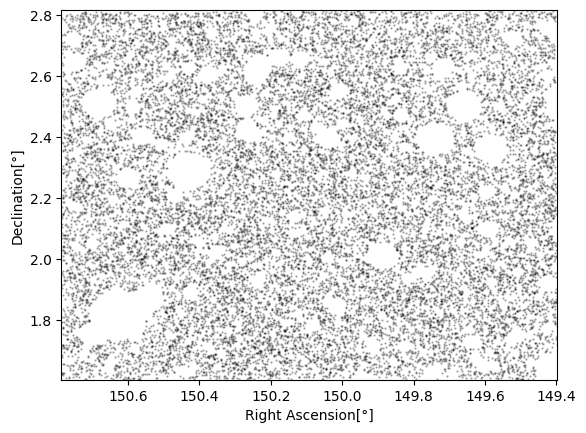

In [35]:
# Select a random subsample for sake of clarity
a = np.random.randint(0,nsrc,size=20000)
plt.scatter(cat['RA'][a],cat['DEC'][a],color='k',s=0.4,alpha=0.3)
plt.xlim(ramax,ramin)
plt.ylim(decmin,decmax)
plt.xlabel('Right Ascension[°]')
plt.ylabel('Declination[°]')
plt.show()

Redshift distributions and GzK diagram.
`lp_zp_2` is the secondary photoz solution in LePhare.
`lp_zq` is the photoz solution in LePhare using QSO/AGN templates. 

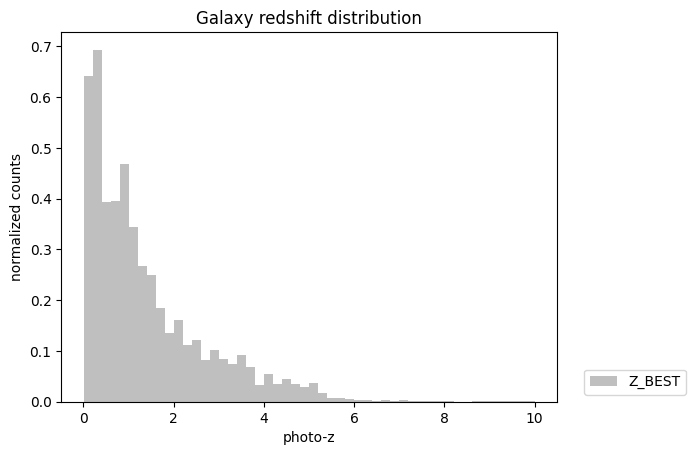

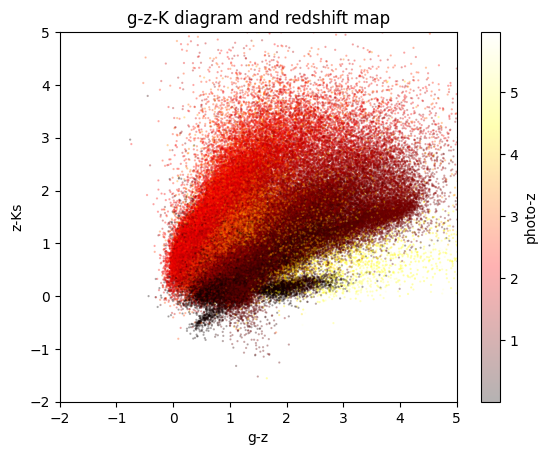

In [36]:
plt.hist(cat['photoz'],range=(0.01,10),log=False,bins=50,density=True,color ='grey',alpha=0.5,label = 'Z_BEST')
# plt.hist(cat['lp_zp_2'],range=(0.01,10),log=False,bins=50,density=True,color ='orange',histtype='step',label = 'Z_SEC')
# plt.hist(cat['lp_zq'][cat['lp_type']==2],range=(0.01,10),log=False,bins=50,density=True,color ='blue',alpha=0.5,label = 'Z_AGN',histtype='step')
plt.title('Galaxy redshift distribution')
plt.xlabel('photo-z')
plt.ylabel('normalized counts')
plt.legend(bbox_to_anchor=(1.04,0),loc='lower left') 
plt.show()

color1 = cat['HSC_g_MAG'] - cat['HSC_z_MAG']
color2 = cat['HSC_z_MAG'] - cat['UVISTA_Ks_MAG']
zmap = cat['photoz']
sel = (cat['photoz']>=0.) & (cat['photoz']<6.) & (cat['UVISTA_Ks_MAG']<24.5)
plt.scatter(color1[sel],color2[sel],c=zmap[sel],cmap='hot',s=0.4,alpha=0.3)
plt.xlim(-2,5)
plt.ylim(-2,5)
cbar=plt.colorbar()
cbar.set_label('photo-z')
plt.xlabel('g-z')
plt.ylabel('z-Ks')

plt.title('g-z-K diagram and redshift map')
plt.show()
    
